In this notebook, look at the data from 100s before the merger time to 100s after. With this, we caan look at the evolution of the SNR as the signal enters the frame of the detector and see when we have the possibility to effectively detect the event in order to send an alert to the observers to point the telescopes

In order to do so, we need first to look at the full analysis to have the SNR in that case. After that, we will slide a window of data from before the possibility to detect anything (which will probably be more or less 100 seconds before the merger appears). Then, we add each time 1s to see when the event becomes visible (correct time) and when the data has the possibility to be looked at. 

The analysis is also done with templates that are better suited to the case of neutron star (see graceDB paper about waveforms).

**duration of the event before ther meger happened:** Not stated but we exepect it to be of the order of 100s. This is verifiable on the Q transform of the full system. The gamma ray signal also happened 1.7s after the merger. So, we can add that 1.7s to the time prior detection

The SNR is the highest in L1 (26.4 reported) and is 18.8 in Hanford. If the process is not too difficult, we caan look in both to see if we would have the same behaviour

In this notebook, we look at the possibility to detect the signal early on, or based only on a fraction of it. In the case of black holes, we subtracted the signal and then added pieces again. However, here, as shown in the NS_analysis notebook, this is not possible. So, we work differently, in case that looks more to what could be done in reality. Therefore, we use a sliding window of 300 duration. It will move in time, with its end starting 100s prior to the data to 100 s after it. 

In order to see if the event is detected, we look at the possibility to have a correct SNR and at the good time. 

**Duration of the event before ther merger happened:** Not stated but we exepect it to be of the order of 100s. This is verifiable on the Q transform of the full system. The gamma ray signal also happened 1.7s after the merger is detected in GW. So, we can add that 1.7s to the time prior detection

The SNR is the highest in L1 (26.4 reported) and is 18.8 in Hanford. If the process is not too difficult, we caan look in both to see if we would have the same behaviour

## For L1, analysis of the full signal0

We do a wuick analysis of the event and see if we can subtract it out of the signal. This give a basis for white noise. 

In [1]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [3]:
#get data around the event, 256 seconds that include the event 
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import sigma
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy 

merger = Merger("GW170817")

strains = {}
stildes = {}

for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strains[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strains[ifo] = strains[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stildes[ifo] = strains[ifo].to_frequencyseries()

In [4]:
strain = strains['L1']
str_freq = stildes['L1']

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


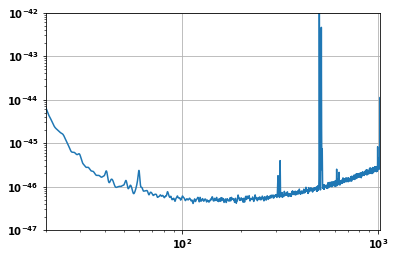

In [5]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(2)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15.0,
                                  trunc_method = 'hann')

plt.loglog(psd.sample_frequencies, psd)
plt.ylim(1e-47, 1e-42)
plt.xlim(20,1024)
plt.grid()

/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


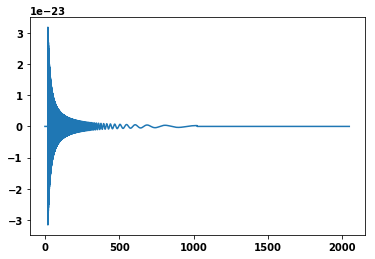

In [6]:
#make the template with the parameters that are found in paper (and graceDB)
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

hp.resize(len(str_freq))

plt.plot(hp.sample_frequencies, hp)

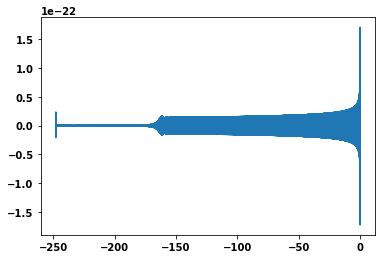

In [7]:
plt.plot(hp.to_timeseries().sample_times, hp.to_timeseries())

In [8]:
#matched filtering with the template made with the paramters given 
#by Mr Cudell
from pycbc.filter import matched_filter
import numpy 

snr = matched_filter(hp, str_freq, psd = psd, 
                      low_frequency_cutoff = 15.0)

snr_z = snr.time_slice(merger.time - 1, merger.time + 1)
_, idx = snr.abs_max_loc()
max_snr = snr[idx]
snr_m = abs(max_snr)
max_t = float(idx)/snr.sample_rate + snr.start_time

print("We found a signal at %.7f with a SNR of %.7f" %(max_t, snr_m))
print(merger.time)


We found a signal at 1187008882.4395509 with a SNR of 15.2219138
1187008882.4


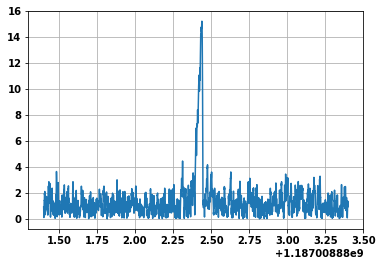

In [9]:
plt.plot(snr_z.sample_times, abs(snr_z))
plt.grid()

Although the SNR is quite small with respect to the published values, this is significant as detection. I hope it is enough to subutract the signal relatively well out of the data 

Text(0,0.5,'Normalized amplitude')

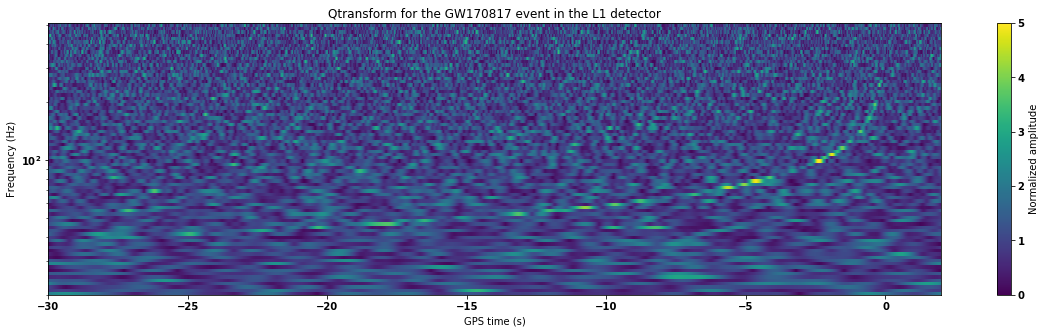

In [10]:
#visualisation of the data with the Q transform

hoft = (str_freq/psd**0.5).to_timeseries()
zoom = hoft.time_slice(merger.time - 30, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t-merger.time, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Qtransform for the GW170817 event in the L1 detector")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

Text(0,0.5,'Normalized amplitude')

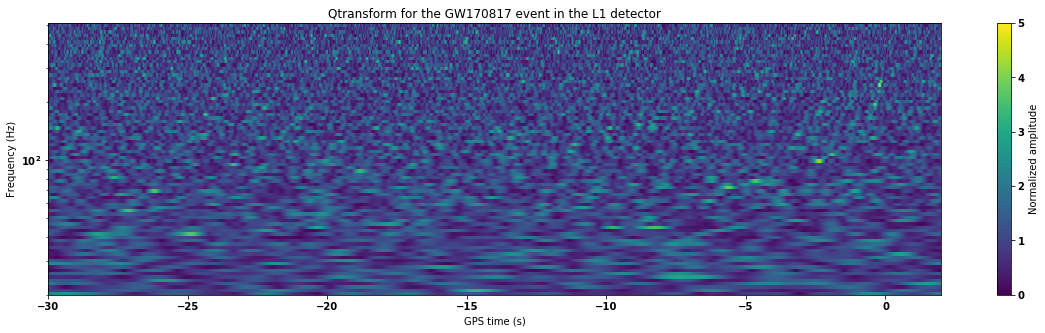

In [11]:
#we try to sibtract the data to see if it is well modeled.
#if the subtraction is well done, we can suppose that this is a good
#representation of the system and that it can be used for the search

from pycbc.filter import sigma

#shift of the template to the correct time
dt = max_t - str_freq.start_time
inj = hp.cyclic_time_shift(dt)

inj/= sigma(hp, psd = psd, low_frequency_cutoff = 15.0)
inj *= max_snr

st2 = str_freq - inj

hoft = (st2/psd**0.5).to_timeseries()

zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t-merger.time, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Qtransform for the GW170817 event in the L1 detector")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

the signal seems to be relatively well subtracted. We know the matching that we should have for the full detector. This means that we have the possibility to do the search for this event for the full system

## Look at the variation of the SNR as function of the data window that is considered

We start with 300 seconds of data with the last second 100s prior to the merger (this means that there could be a small part of the inspiral already present). We then let the data window considered go 1second further. After 100 itterations, we shoulde encapsulate fully the event. We take a window of 256 second. Start with the case where the last sample is 100 second before the time of the merger and end when the we are 1 second after the merger. This means that there will be a moment where the signal is fully encapsulated and that we should stay at the maximum, before droping again, once we start losing a significant part of the signal. 

In [14]:
import numpy as np

end_times = np.arange(-100, 206, 1)
start_times = np.arange(-356, -50, 1)
print(len(end_times), len(start_times))

(306, 306)


In [15]:
import numpy as np

snrs = []
times = []

end_times = np.arange(-100, 206, 1)
start_times = np.arange(-356, -50, 1)

result_file = open("NS_sliding_windowSNR.txt", "w")



for i in range(len(start_times)):
    print("Itteration %i  / %i" %(i, len(end_times)))
    #download and prepare the data frame
    ts = read_frame("L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'L1:LOSC-STRAIN',
                   start_time=merger.time + start_times[i],
                   end_time=merger.time + end_times[i],
                   check_integrity=False)
    strain = highpass(ts, 15)
    strain = strain.crop(4,4)
    str_freq = strain.to_frequencyseries()
    
    #psd of the data
    
    psd = strain.psd(2)
    psd = interpolate(psd, strain.delta_f)
    psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                           low_frequency_cutoff = 15.0,
                                          trunc_method = 'hann')
    
    #rebuild the template to be sure that it is the correct size
    
    hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

    hp.resize(len(str_freq))
    
    #matched filtering
    snr = matched_filter(hp, str_freq, psd = psd, 
                         low_frequency_cutoff = 15.0)
    _, idx = snr.abs_max_loc()
    max_snr = snr[idx]
    snr_m = abs(max_snr)
    max_t = float(idx)/snr.sample_rate + snr.start_time
    
    snrs.append(snr_m)
    times.append(max_t)
    
    #write what is obtained into a text file
    result_file.write("start time: %i, end time: %.4f, SNR: %.7f found at time %.7f /n" %(start_times[i], (merger.time+end_times[i]), snr_m, max_t))
    
    print("Done")
    




Itteration 0  / 306
Done
Itteration 1  / 306
Done
Itteration 2  / 306
Done
Itteration 3  / 306
Done
Itteration 4  / 306
Done
Itteration 5  / 306
Done
Itteration 6  / 306
Done
Itteration 7  / 306
Done
Itteration 8  / 306
Done
Itteration 9  / 306
Done
Itteration 10  / 306
Done
Itteration 11  / 306
Done
Itteration 12  / 306
Done
Itteration 13  / 306
Done
Itteration 14  / 306
Done
Itteration 15  / 306
Done
Itteration 16  / 306
Done
Itteration 17  / 306
Done
Itteration 18  / 306
Done
Itteration 19  / 306
Done
Itteration 20  / 306
Done
Itteration 21  / 306
Done
Itteration 22  / 306
Done
Itteration 23  / 306
Done
Itteration 24  / 306
Done
Itteration 25  / 306
Done
Itteration 26  / 306
Done
Itteration 27  / 306
Done
Itteration 28  / 306
Done
Itteration 29  / 306
Done
Itteration 30  / 306
Done
Itteration 31  / 306
Done
Itteration 32  / 306
Done
Itteration 33  / 306
Done
Itteration 34  / 306
Done
Itteration 35  / 306
Done
Itteration 36  / 306
Done
Itteration 37  / 306
Done
Itteration 38  / 306
D

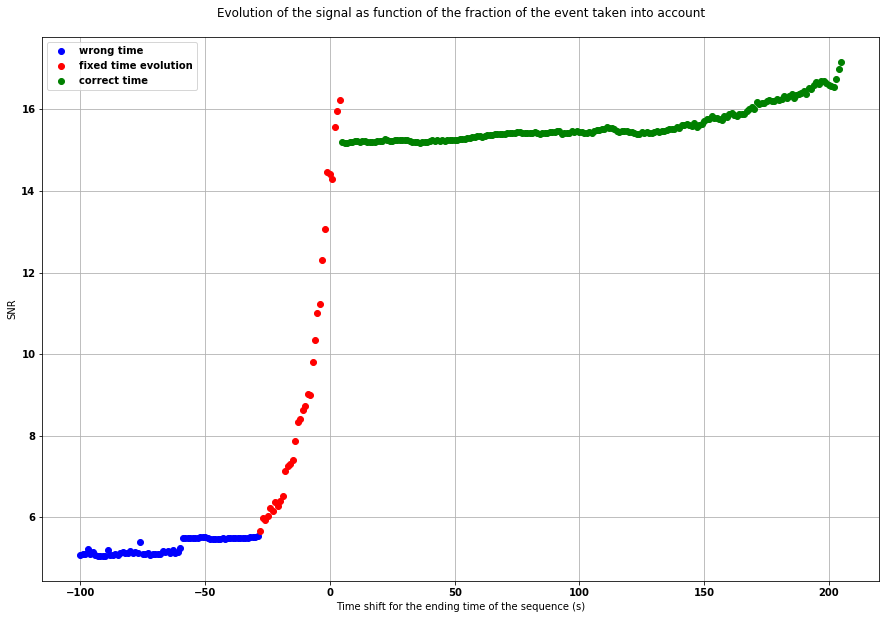

In [16]:
j = 1
l = 1
k = 1

plt.figure(figsize = [15,10])

for i in range(len(snrs)):
    if int(times[i]) == 1187008882:
        if j == 1:
            plt.plot(end_times[i], snrs[i], 'og', label= 'correct time')
            j = 12
        else:
            plt.plot(end_times[i], snrs[i], 'og')
    elif int(times[i]) == 1187008634:
        if k == 1:
            plt.plot(end_times[i], snrs[i], 'or', label = 'fixed time evolution')
            k = 12
        else:
            plt.plot(end_times[i], snrs[i], 'or')
    else:
        if l == 1:
            plt.plot(end_times[i], snrs[i], 'ob', label = 'wrong time')
            l = 12
        else:
            plt.plot(end_times[i], snrs[i], 'ob')
        

plt.title("Evolution of the signal as function of the fraction of the event taken into account", 
          pad = 20)
plt.xlabel("Time shift for the ending time of the sequence (s)")
plt.ylabel("SNR")
plt.grid()
plt.legend(loc='best')

The red part show an evolution as if the signal was present, with a growth of the values similar to what is seen in the case of the black holes but at the wrong time. This could be due to the signal that would be present and lead to that increase

The evolution could be better seen if we had the opportunity to macth the template in the same way than for the balck hole. A way to do that is to stitch a noise time series (of 100s) for example, where the template would be able to slide and see if we do not get a better match at the end, and at time the looks more similar to that where the event will happen.

First, we need to look wheter it is possible to add noise to the time series to have a continuous value before doing the analysis again, whith the same times than before.

Twoo ideas are tested: first te addition of gaussian noise generated based on the PSD and the addition of a time series that comes from the detector and where no event has been detected.

In [17]:
#trial to stitch a noise time series to the data that is downloaded
# here, we juste try for the sequence with the event and checkt that it 
#does not give rise a glitch due to discontinuities

from pycbc.noise import gaussian as gs
import numpy as np

#aata acquisition

strains = {}
stildes = {}

for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strains[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strains[ifo] = strains[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stildes[ifo] = strains[ifo].to_frequencyseries()

strain = strains['L1']
str_freq = stildes['L1']

#make psd that will be used to generate the noise
psd = strain.psd(2)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15.0,
                                  trunc_method = 'hann')

#make noise from psd
noise = gs.frequency_noise_from_psd(psd, seed = 12)
noise_T = np.array(0.0001*noise.to_timeseries() )

noise_tot = np.hstack((noise_T, noise_T, noise_T)) 



noise_tot is just 3 times the 32 seconds of noise that are stitched together. Now, we can use the same trick to append these 96seconds to our data

In [18]:
from pycbc.types import TimeSeries

strain_array = np.array(strain)
signal = np.hstack((strain_array, noise_tot))
signalTS = TimeSeries(signal, delta_t = strain.delta_t, epoch = strain.start_time)

Text(0,0.5,'Normalized amplitude')

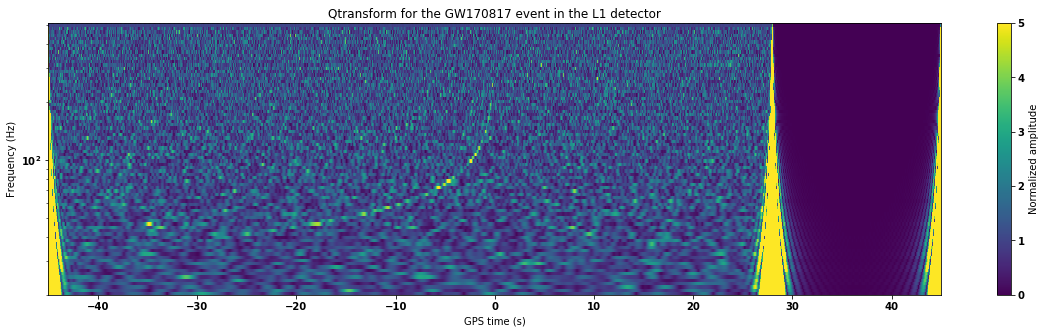

In [19]:
#qtransform of the stitched signal to see of we can still see the signal
#and if we have the expected signal

#we look at the transition, not the full signal

zoom = signalTS.time_slice(merger.time - 45, merger.time + 45)

t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t-merger.time, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Qtransform for the GW170817 event in the L1 detector")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

When stitching the noise, there are glitches that appear in the data. Those become less important as we decrease the amplitude of the noise that is added. A way to avoid the glitches could be to add noise that is more similar to the data itself. For example, we could use data where no signal is present and add it. As it is noise directly from the detector and not gaussian noise coloured by the psd, it could be more adapted 

In [20]:
#test of importing data without signa$l (start of the data in the file
# present here

ts = read_frame("L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'L1:LOSC-STRAIN',
                   start_time = 1187007040,
                   end_time= 1187007040 + 100,
                   check_integrity=False)
no_dat = highpass(ts, 15)
no_dat = no_dat.crop(4,4)

Text(0,0.5,'Normalized amplitude')

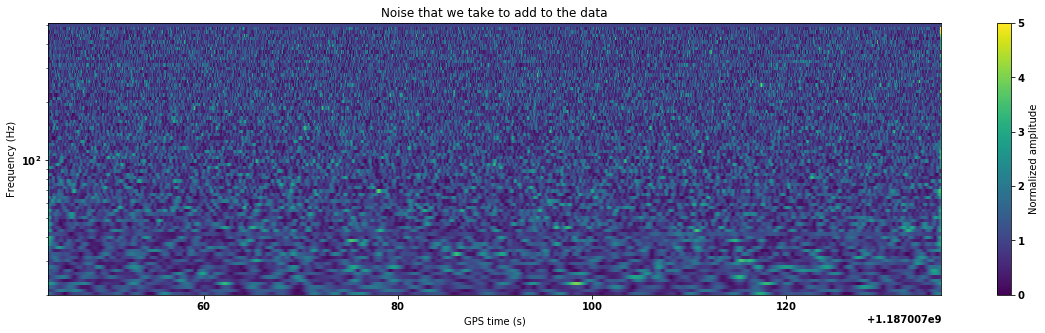

In [21]:
#we look at a qtransform of the data to verify the absence of signal and
#glitches

t, f, p = no_dat.qtransform(.01, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Noise that we take to add to the data")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

As the data seems clean, we can add it to the strain signal

In [22]:
noise_array = np.array(no_dat)
strain_array = np.array(strain)

signal = np.hstack((strain_array, noise_array))
signalTS = TimeSeries(signal, delta_t = strain.delta_t, epoch = merger.time - 224)

Text(0,0.5,'Normalized amplitude')

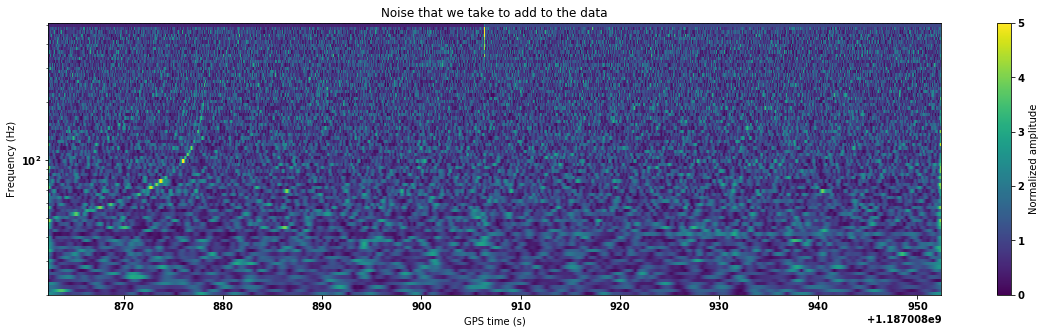

In [23]:
#we look if the glitches ar as strong as those for the PSD made noise

zoom = signalTS.time_slice(merger.time - 20, merger.time + 70)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Noise that we take to add to the data")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

When we use data that is taken out of the signal, we see that no glitch is present. SO, we will use this to extend our signal further away and make the matched filtering possible.

## Look at the evolution of the SNR as function of the signal if we add a bit of data without signal after it.

First, we need an array that will be added to the signal

In [24]:
ts = read_frame("L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'L1:LOSC-STRAIN',
                   start_time = 1187007040,
                   end_time= 1187007040 + 90,
                   check_integrity=False)
noise = highpass(ts, 15)
noise = noise.crop(4,4)
noise_array = np.array(noise)

Text(0,0.5,'Normalized amplitude')

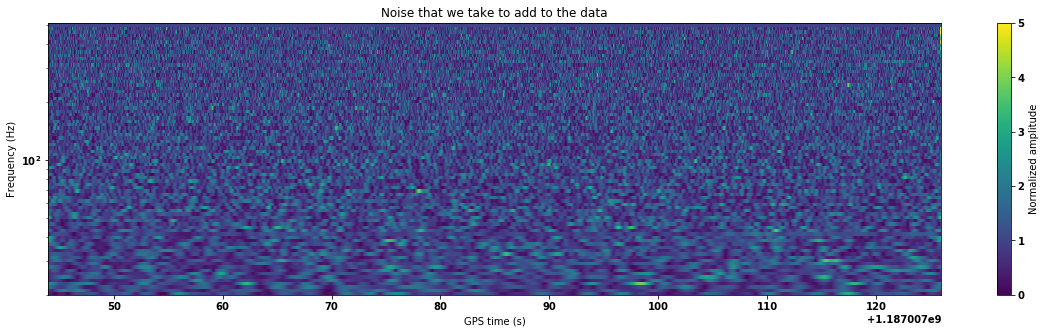

In [25]:
#check signal
t, f, p = noise.qtransform(.01, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Noise that we take to add to the data")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

In [26]:
snrs = []
times = []

end_times = np.arange(-100, 206, 1)
start_times = np.arange(-356, -50, 1)

result_file = open("NS_sliding_windowSNR_withNoise.txt", "w")



for i in range(len(start_times)):
    print("Itteration %i  / %i" %(i, len(end_times)))
    #download and prepare the data frame
    ts = read_frame("L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'L1:LOSC-STRAIN',
                   start_time=merger.time + start_times[i],
                   end_time=merger.time + end_times[i],
                   check_integrity=False)
    strain = highpass(ts, 15)
    strain = strain.crop(4,4)
    
    #build the signal with the noise added
    strain_array = np.array(strain)
    sig = np.hstack((strain_array, noise_array))
    signal = TimeSeries(sig, delta_t = strain.delta_t, 
                        epoch = strain.start_time)
    
    #new data in the frequency domain
    str_freq = signal.to_frequencyseries()
    
     #psd of the data
    
    psd = signal.psd(2)
    psd = interpolate(psd, signal.delta_f)
    psd = inverse_spectrum_truncation(psd, 2*signal.sample_rate, 
                                           low_frequency_cutoff = 15.0,
                                          trunc_method = 'hann')
    
    #rebuild the template to be sure that it is the correct size
    
    hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

    hp.resize(len(str_freq))
    
    #matched filtering
    snr = matched_filter(hp, str_freq, psd = psd, 
                         low_frequency_cutoff = 15.0)
    _, idx = snr.abs_max_loc()
    max_snr = snr[idx]
    snr_m = abs(max_snr)
    max_t = float(idx)/snr.sample_rate + snr.start_time
    
    snrs.append(snr_m)
    times.append(max_t)
    
    #write what is obtained into a text file
    result_file.write("start time: %i, end time: %.4f, SNR: %.7f found at time %.7f /n" %(start_times[i], (merger.time+end_times[i]), snr_m, max_t))
    
    print("Done")
    




Itteration 0  / 306
Done
Itteration 1  / 306
Done
Itteration 2  / 306
Done
Itteration 3  / 306
Done
Itteration 4  / 306
Done
Itteration 5  / 306
Done
Itteration 6  / 306
Done
Itteration 7  / 306
Done
Itteration 8  / 306
Done
Itteration 9  / 306
Done
Itteration 10  / 306
Done
Itteration 11  / 306
Done
Itteration 12  / 306
Done
Itteration 13  / 306
Done
Itteration 14  / 306
Done
Itteration 15  / 306
Done
Itteration 16  / 306
Done
Itteration 17  / 306
Done
Itteration 18  / 306
Done
Itteration 19  / 306
Done
Itteration 20  / 306
Done
Itteration 21  / 306
Done
Itteration 22  / 306
Done
Itteration 23  / 306
Done
Itteration 24  / 306
Done
Itteration 25  / 306
Done
Itteration 26  / 306
Done
Itteration 27  / 306
Done
Itteration 28  / 306
Done
Itteration 29  / 306
Done
Itteration 30  / 306
Done
Itteration 31  / 306
Done
Itteration 32  / 306
Done
Itteration 33  / 306
Done
Itteration 34  / 306
Done
Itteration 35  / 306
Done
Itteration 36  / 306
Done
Itteration 37  / 306
Done
Itteration 38  / 306
D

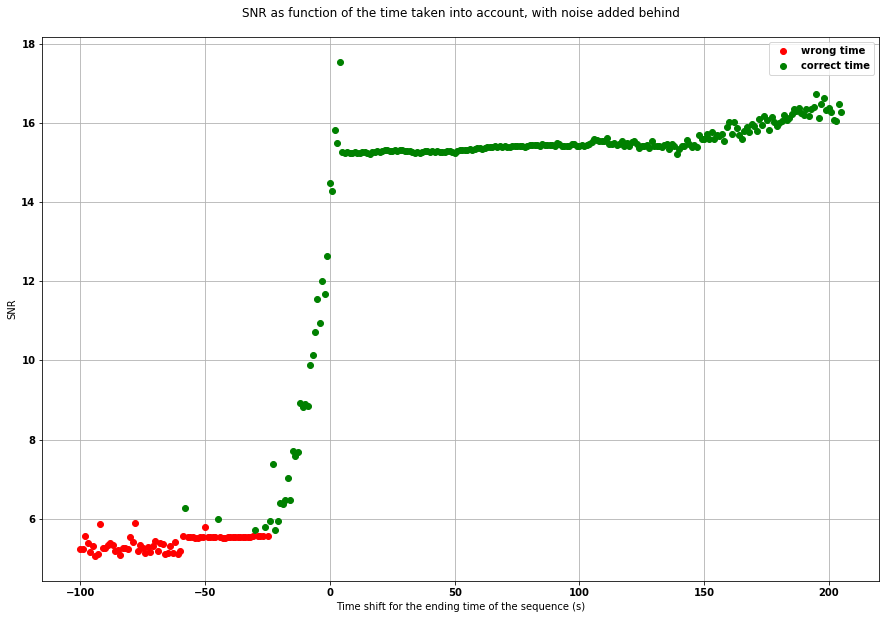

In [27]:
j = 1
k = 1

plt.figure(figsize = [15, 10])

for i in range(len(snrs)):
    if int(times[i]) == 1187008882 :
        if j == 1 :
            plt.plot(end_times[i], snrs[i], 'og', label = 'correct time')
            j = 12
        else:
            plt.plot(end_times[i], snrs[i], 'og')
    else:
        if k == 1:
            plt.plot(end_times[i], snrs[i], 'or', label = 'wrong time')
            k = 12
        else:
            plt.plot(end_times[i], snrs[i], 'or')
            
plt.title("SNR as function of the time taken into account, with noise added behind", 
          pad = 20)
plt.xlabel("Time shift for the ending time of the sequence (s)")
plt.ylabel("SNR")
plt.grid()
plt.legend(loc = 'best')

In [29]:
#with the best fit parameter found in the online examples

snrs = []
times = []

end_times = np.arange(-100, 206, 1)
start_times = np.arange(-356, -50, 1)

result_file = open("NS_sliding_windowSNparam_online_ex.txt", "w")

m = 1.38


for i in range(len(start_times)):
    print("Itteration %i  / %i" %(i, len(end_times)))
    #download and prepare the data frame
    ts = read_frame("L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'L1:LOSC-STRAIN',
                   start_time=merger.time + start_times[i],
                   end_time=merger.time + end_times[i],
                   check_integrity=False)
    strain = highpass(ts, 15)
    strain = strain.crop(4,4)
    
    #build the signal with the noise added
    strain_array = np.array(strain)
    sig = np.hstack((strain_array, noise_array))
    signal = TimeSeries(sig, delta_t = strain.delta_t, 
                        epoch = strain.start_time)
    
    #new data in the frequency domain
    str_freq = signal.to_frequencyseries()
    
     #psd of the data
    
    psd = signal.psd(2)
    psd = interpolate(psd, signal.delta_f)
    psd = inverse_spectrum_truncation(psd, 2*signal.sample_rate, 
                                           low_frequency_cutoff = 15.0,
                                          trunc_method = 'hann')
    
    #rebuild the template to be sure that it is the correct size
    
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=str_freq.delta_f)

    hp.resize(len(str_freq))
    
    #matched filtering
    snr = matched_filter(hp, str_freq, psd = psd, 
                         low_frequency_cutoff = 15.0)
    _, idx = snr.abs_max_loc()
    max_snr = snr[idx]
    snr_m = abs(max_snr)
    max_t = float(idx)/snr.sample_rate + snr.start_time
    
    snrs.append(snr_m)
    times.append(max_t)
    
    #write what is obtained into a text file
    result_file.write("start time: %i, end time: %.4f, SNR: %.7f found at time %.7f /n" %(start_times[i], (merger.time+end_times[i]), snr_m, max_t))
    
    print("Done")
    




Itteration 0  / 306
Done
Itteration 1  / 306
Done
Itteration 2  / 306
Done
Itteration 3  / 306
Done
Itteration 4  / 306
Done
Itteration 5  / 306
Done
Itteration 6  / 306
Done
Itteration 7  / 306
Done
Itteration 8  / 306
Done
Itteration 9  / 306
Done
Itteration 10  / 306
Done
Itteration 11  / 306
Done
Itteration 12  / 306
Done
Itteration 13  / 306
Done
Itteration 14  / 306
Done
Itteration 15  / 306
Done
Itteration 16  / 306
Done
Itteration 17  / 306
Done
Itteration 18  / 306
Done
Itteration 19  / 306
Done
Itteration 20  / 306
Done
Itteration 21  / 306
Done
Itteration 22  / 306
Done
Itteration 23  / 306
Done
Itteration 24  / 306
Done
Itteration 25  / 306
Done
Itteration 26  / 306
Done
Itteration 27  / 306
Done
Itteration 28  / 306
Done
Itteration 29  / 306
Done
Itteration 30  / 306
Done
Itteration 31  / 306
Done
Itteration 32  / 306
Done
Itteration 33  / 306
Done
Itteration 34  / 306
Done
Itteration 35  / 306
Done
Itteration 36  / 306
Done
Itteration 37  / 306
Done
Itteration 38  / 306
D

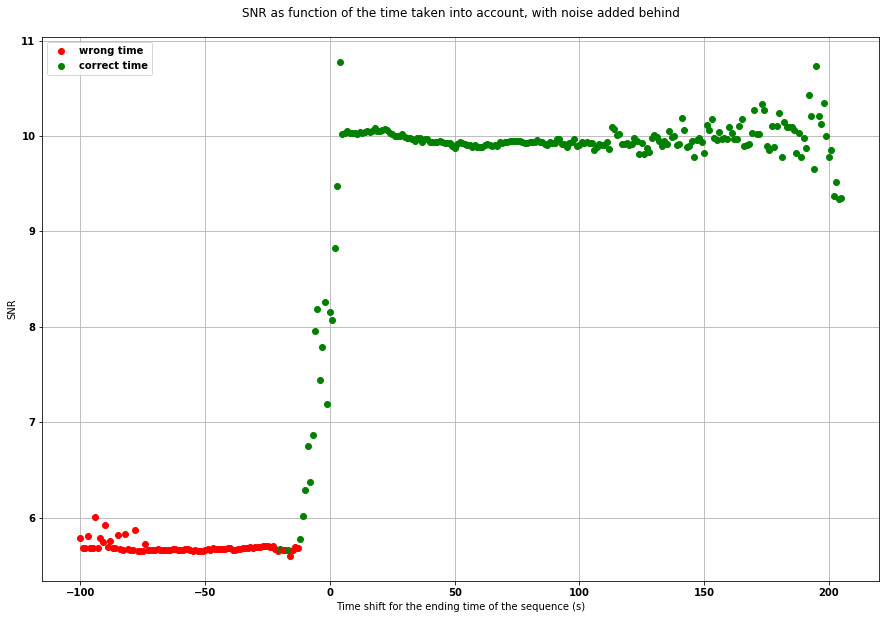

In [30]:
j = 1
k = 1

plt.figure(figsize = [15, 10])

for i in range(len(snrs)):
    if int(times[i]) == 1187008882 :
        if j == 1 :
            plt.plot(end_times[i], snrs[i], 'og', label = 'correct time')
            j = 12
        else:
            plt.plot(end_times[i], snrs[i], 'og')
    else:
        if k == 1:
            plt.plot(end_times[i], snrs[i], 'or', label = 'wrong time')
            k = 12
        else:
            plt.plot(end_times[i], snrs[i], 'or')
            
plt.title("SNR as function of the time taken into account, with noise added behind", 
          pad = 20)
plt.xlabel("Time shift for the ending time of the sequence (s)")
plt.ylabel("SNR")
plt.grid()
plt.legend(loc = 'best')